In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

import glam as gb

%load_ext autoreload
%autoreload 2

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# --- NO OFFSET IMPLEMENTATION ---

# Example 2: Three small groups with difference in gaze bias

In some research settings, the total amount of data one can possibly gather can be small, conflicting with the large required amounts of data necessary to obtain reliable and precise parameter estimates from diffusion models (Reference for No. of trials needed to fit diffusion models). Hierarchical modeling offers another solution to the problem. Here, each individual's parameter estimates are assumed to be drawn from a group level distribution. Thereby, during parameter estimation, data on the individual level informs estimates of parameters of the group, to the extent that they are informative. In turn, individual estimates are constrained by the group level distributions. Such hierarchical parameter estimation can greatly improve parameter estimation in face of limited amounts of data (cf. the HDDM toolbox for hierarchical modeling using the Drift Diffusion Model).

Here, we will simulate a clinical application setting, in which different patient groups are to be compared on their gaze biases during a simple value-based choice task that includes eye tracking. It is reasonable to assume that the amount of data that can be generated in such a setting is limited on at least two accounts:

1. The number of patients with certain conditions that are available for the experiment might be low
2. The number of trials that can be performed by each individual might also be low, for clinical reasons (e.g., patients feel exhausted earlier, ...)

Therefore, the dataset we simulate will contain only low numbers of individuals within each group, and only 100 trials (roughly corresponding to a 30-minute experimental) per participant.

We will then estimate model parameters in a hierarchical fashion, and compare the group level gaze bias parameters between groups.

## Simulate data

We simulate data of three patient groups ($N_1 = 10$, $N_2 = 15$, $N_3 = 20$), with 100 trials per patient. This is a dataset of rather limited size. We only let the gaze bias parameter $\gamma$ differ between the groups, with means of $\gamma_1 = 0.7$ (weak gaze bias), $\gamma_2 = 0.3$ (moderate gaze bias) and $\gamma_3 = -0.5$ (strong gaze bias), respectively. All other parameters are drawn from the same distributions across groups:

In [2]:
np.random.seed(1038)

N = dict(group1=10,
         group2=15,
         group3=20)

v = dict(group1=np.clip(np.random.normal(loc=0.0001, scale=0.000025, size=N['group1']), a_min=0, a_max=None),
         group2=np.clip(np.random.normal(loc=0.0001, scale=0.000025, size=N['group2']), a_min=0, a_max=None),
         group3=np.clip(np.random.normal(loc=0.0001, scale=0.000025, size=N['group3']), a_min=0, a_max=None))

s = dict(group1=np.clip(np.random.normal(loc=0.006, scale=0.0005, size=N['group1']), a_min=0, a_max=None),
         group2=np.clip(np.random.normal(loc=0.006, scale=0.0005, size=N['group2']), a_min=0, a_max=None),
         group3=np.clip(np.random.normal(loc=0.006, scale=0.0005, size=N['group3']), a_min=0, a_max=None))

gamma = dict(group1=np.clip(np.random.normal(loc= 0.7, scale=0.3, size=N['group1']), a_min=None, a_max=1),
             group2=np.clip(np.random.normal(loc= 0.3, scale=0.3, size=N['group2']), a_min=None, a_max=1),
             group3=np.clip(np.random.normal(loc=-0.5, scale=0.3, size=N['group3']), a_min=None, a_max=1))

tau = dict(group1=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group1']), a_min=0, a_max=None),
           group2=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group2']), a_min=0, a_max=None),
           group3=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group3']), a_min=0, a_max=None))

n_trials = 50
n_items  = 3

glam = gb.GLAM()

groups = ['group1', 'group2', 'group3']

for group in groups:
    glam.simulate_group(kind='individual', n_individuals=N[group], n_trials=n_trials, n_items=n_items,
                         parameters=dict(v=v[group], gamma=gamma[group], s=s[group], t0=np.zeros(N[group]), tau=tau[group]),
                         label=group)

data = glam.data.copy()
data.rename({'condition': 'group'}, axis=1, inplace=True)

These are the distributions of data-generating parameters:

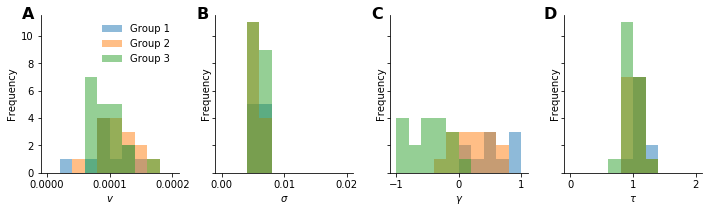

In [3]:
import string
group_names = ['Group 1', 'Group 2', 'Group 3']
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
for p, (parameter, parameter_name, bins) in enumerate(zip([v, s, gamma, tau],
                                                [r'$v$', r'$\sigma$', r'$\gamma$', r'$\tau$'],
                                                [np.linspace(0, 0.0002, n_bins + 1), np.linspace(0, 0.02, n_bins + 1),
                                                 np.linspace(-1, 1, n_bins + 1), np.linspace(0, 2, n_bins + 1)])):
    for g, (group, name) in enumerate(zip(groups, group_names)):
        axs[p].hist(parameter[group],
                    bins=bins,
                    color='C{}'.format(g),
                    label=name,
                    alpha=0.5)
        axs[p].set_xlabel(parameter_name)
        axs[p].set_ylabel('Frequency')
        axs[p].spines['top'].set_visible(False)
        axs[p].spines['right'].set_visible(False)

for ax, letter in zip(axs, string.ascii_uppercase[:axs.size]):
    ax.text(-0.05, 1.05, letter, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon=False)
fig.tight_layout()

It can be seen, that the groups primarily differ in the gaze bias parameter $\gamma$ (**C**), whereas other parameters largely overlap (even though there exists of course some variance between individuals).

We can plot different aspects of the data, to see behavioural differences between groups (white bars represent pooled data across groups; coloured lines represent individual groups):

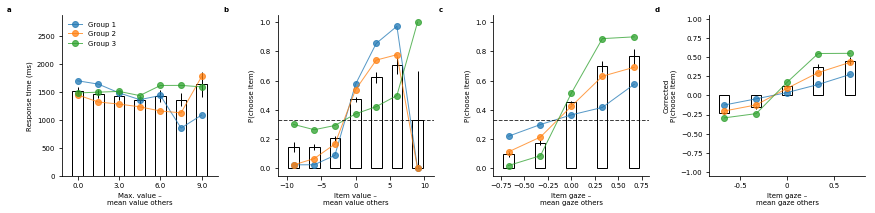

In [4]:
gb.plots.absolute_fit_aggregate(bar_data=data,
                                  line_data=[data.loc[data['group'] == group] for group in groups],
                                  line_labels=group_names,
                                  value_bins=7, gaze_bins=7);

Even though the data were generated only with different gaze biases, the groups behaviourally also differ in response times (**A**; with Group 1 being slower than Groups 2 and 3 for trials with high difficulty, where the best item is only slightly better than the others) and choice accuracy (**B**; Group 3 clearly less accurate than the others). As was to be expected, we can also observe behavioural differences in gaze influence measures (**C** and **D**), where the choices Group 3 are driven by gaze much stronger than those of the other groups.

## Hierarchical model

We now set up the hierarchical model, assuming that every group has a distinct average gaze bias, which we will then estimate.

![glam_hierarchical_illustration](figures/hierarchical_glam_illustration.png)

!! Include a section to talk about priors. !!

In [5]:
hglam = gb.GLAM(data=data)
hglam.make_model(kind='hierarchical',
                 depends_on=dict(v='group',
                                 gamma='group',
                                 s='group',
                                 tau='group'),
                 t0_val=0)

Generating hierarchical model for 45 subjects...


As for the individual models, we first initialize the model object using the `GLAM` method and supply it with the behavioural data using the `data` argument. To build the corresponding `PyMC3` model, we call the `make_model` method. Here, we set the model `kind` to `hierarchical` (in contrast to an `individual` model). Further, we specify that each model parameter can vary between `group`s (referring to the group variable name in the data) using the `depends_on` argument. This argument expects a dictionary, where keys are the names of parameters with dependencies, and values are names of the (categorical) variables in the data, on which parameters depend. Note that lists of multiple dependencies can also be given (e.g., `dict(v=['group', 'condition'])`).

### MCMC

Now that the model is built, the next step is to perform statistical inference over its parameters. As we have done with the individual models, we can use a traditional Markov-Chain-Monte-Carlo approach, with the Metropolis-Hastings algorithm. While this algorithm produces highly correlated samples, it can still obtain a reasonable number of effective samples, because it runs relatively fast. However, convergence should always diagnosed (References). We recommend to draw as many samples as possible within your time frame, and especially allowing the sampler to tune itself to make sure it is exploring the appropriate region of the parameter space. If you observe slow drifts in the traces, consider increasing the number of tuning samples further. Even though the sampler can be parallelized, each chain running in parallel needs to draw the same number of tuning samples, so this process unfortunately cannot be cut short. Thinning of the samples is not recommended (References).

In [6]:
hglam.fit(method='MCMC', step=pm.Metropolis,
          draws=50000, tune=250000,
          cores=4, chains=4,
          seed=1007,
          progressbar=True)

Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_group3]
>Metropolis: [tau_group2]
>Metropolis: [tau_group1]
>Metropolis: [tau_group3_sd]
>Metropolis: [tau_group2_sd]
>Metropolis: [tau_group1_sd]
>Metropolis: [tau_group3_mu]
>Metropolis: [tau_group2_mu]
>Metropolis: [tau_group1_mu]
>Metropolis: [s_group3]
>Metropolis: [s_group2]
>Metropolis: [s_group1]
>Metropolis: [s_group3_sd]
>Metropolis: [s_group2_sd]
>Metropolis: [s_group1_sd]
>Metropolis: [s_group3_mu]
>Metropolis: [s_group2_mu]
>Metropolis: [s_group1_mu]
>Metropolis: [gamma_group3]
>Metropolis: [gamma_group2]
>Metropolis: [gamma_group1]
>Metropolis: [gamma_group3_sd]
>Metropolis: [gamma_group2_sd]
>Metropolis: [gamma_group1_sd]
>Metropolis: [gamma_group3_mu]
>Metropolis: [gamma_group2_mu]
>Metropolis: [gamma_group1_mu]
>Metropolis: [v_group3]
>Metropolis: [v_group2]
>Metropolis: [v_group1]
>Metropolis: [v_group3_sd]
>Metropolis: [v_group2_sd]
>Metropolis: [v_group1_sd]
>Metropolis: [v_group3_mu]
>Metropo

/!\ Automatically setting parameter precision...


To start the estimation procedure, we call the `fit` method on the model object. The method defaults to traditional Metropolis-Hastings MCMC sampling. The `draws` argument determines the number of samples to be drawn. This excludes the tuning (or burn-in) samples, which can be set with the `tune` argument. In addition, the `fit` method accepts the same keyword arguments as the `PyMC3` `sample` function, which it  wraps (see `PyMC3` documentation for additional details). The most commonly used additional arguments are `chains`, which sets the number of MCMC chains (this should be set to at least two, in order to compute convergence criteria) and `cores`, which sets the number of CPU-cores to be used. `PyMC3` supports parallel sampling of chains, so that sampling time can be reduced. We recommend to sample 4 chains on 4 CPU-cores, if possible.

The resulting MCMC traces should be checked for convergence. Therefore it is helpful to visually inspect the sampled chains:

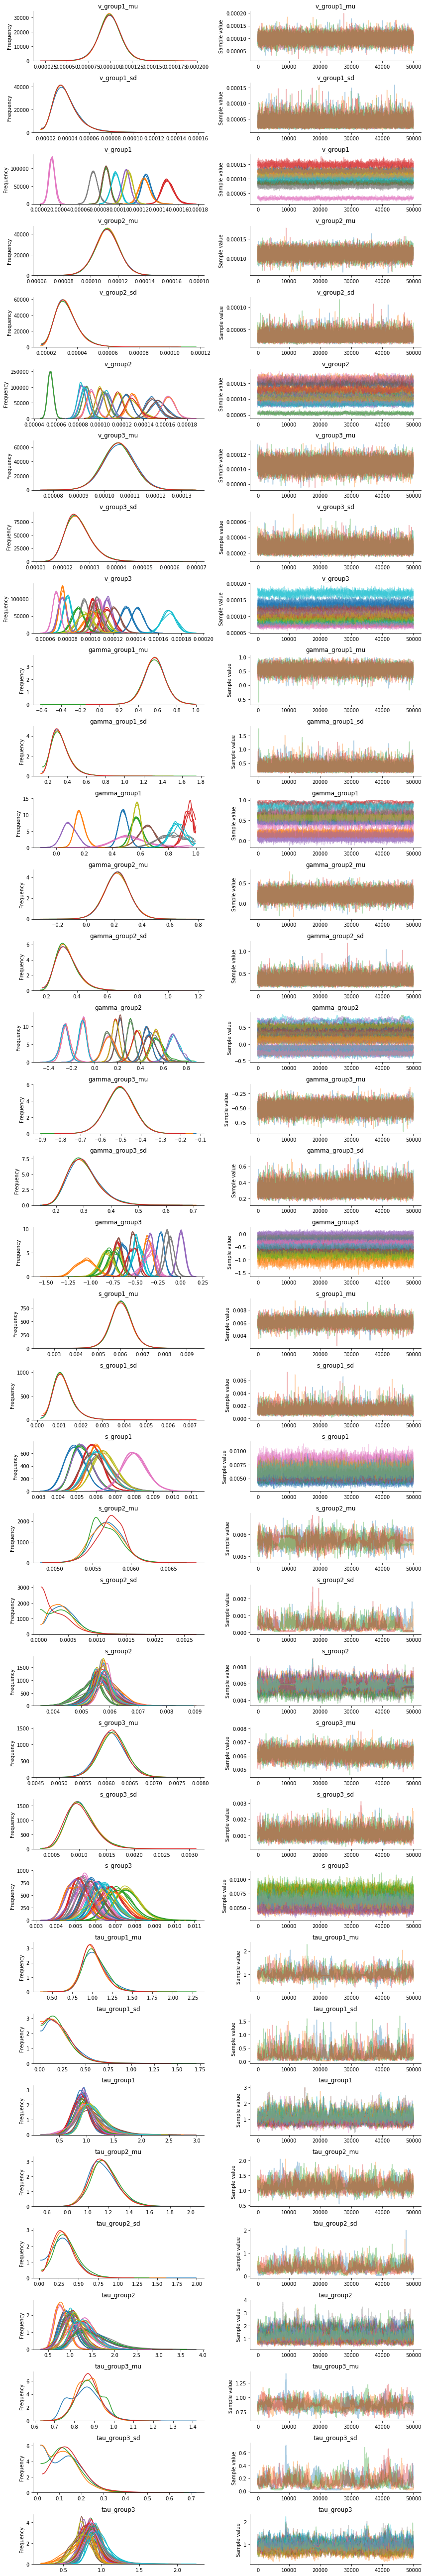

In [7]:
pm.traceplot(hglam.trace[0],
             varnames=['v_group1_mu', 'v_group1_sd', 'v_group1',
                       'v_group2_mu', 'v_group2_sd', 'v_group2',
                       'v_group3_mu', 'v_group3_sd', 'v_group3',
                       'gamma_group1_mu', 'gamma_group1_sd', 'gamma_group1',
                       'gamma_group2_mu', 'gamma_group2_sd', 'gamma_group2',
                       'gamma_group3_mu', 'gamma_group3_sd', 'gamma_group3',
                       's_group1_mu', 's_group1_sd', 's_group1',
                       's_group2_mu', 's_group2_sd', 's_group2',
                       's_group3_mu', 's_group3_sd', 's_group3',
                       'tau_group1_mu', 'tau_group1_sd', 'tau_group1',
                       'tau_group2_mu', 'tau_group2_sd', 'tau_group2',
                       'tau_group3_mu', 'tau_group3_sd', 'tau_group3'],
             combined=False);

In addition, the Gelman-Rubin R-hat statistic of each variable can be inspected:

In [8]:
pm.summary(hglam.trace[0])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,1.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,NaN,NaN
p_error,0.050000,7.450581e-09,7.450581e-10,0.050000,0.050000,2.000061,0.999990
v_group1_mu,0.000099,1.287614e-05,1.063898e-07,0.000074,0.000125,21253.866521,1.000096
v_group2_mu,0.000112,8.978763e-06,7.755004e-08,0.000094,0.000130,17734.402211,1.000096
v_group3_mu,0.000106,6.067369e-06,7.971936e-08,0.000094,0.000118,8218.841880,1.000688
v_group1_sd,0.000039,1.154295e-05,9.932552e-08,0.000021,0.000062,20934.753483,1.000378
v_group2_sd,0.000033,7.330336e-06,5.821572e-08,0.000021,0.000048,18418.834158,0.999999
v_group3_sd,0.000026,4.795169e-06,5.292351e-08,0.000018,0.000036,13204.857265,1.000086
v_group1__0,0.000127,4.903340e-06,1.371522e-07,0.000118,0.000138,1176.613969,1.000718
v_group1__1,0.000126,5.733468e-06,2.028481e-07,0.000114,0.000137,753.052993,1.002240


#### Parameter estimates

With the sampling done, and convergence checked, we can turn back to the research question: Do the 
groups differ with respect to their gaze biases? Questions about differences of group level parameters between groups or conditions can be straightforwardly addressed simply inspecting the posterior distribution of the model parameters. For example, the probability that the mean $\gamma_{\mu, 1}$ for Group 1 was larger than the mean $\gamma_{\mu, 2}$ of Group 2 is given by the proportion of posterior samples in which this was the case. The sampled trace is attached to the model as `model.trace` and can be inspected for further analysis.

The toolbox includes a `plot_node` function that plots posterior distributions of group level parameters. Additionally, the user can specify a list of comparisons between groups or conditions. If comparisons are specified, posterior distributions of differences between groups or conditions, and relevant statistics are added to the figure:

v


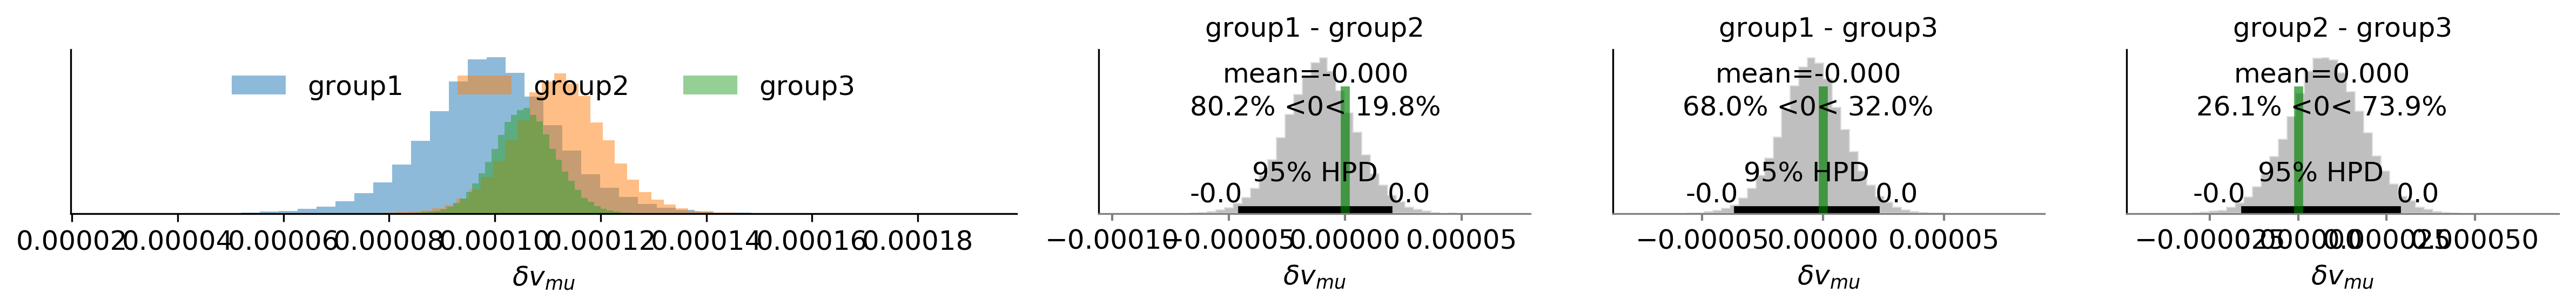

gamma


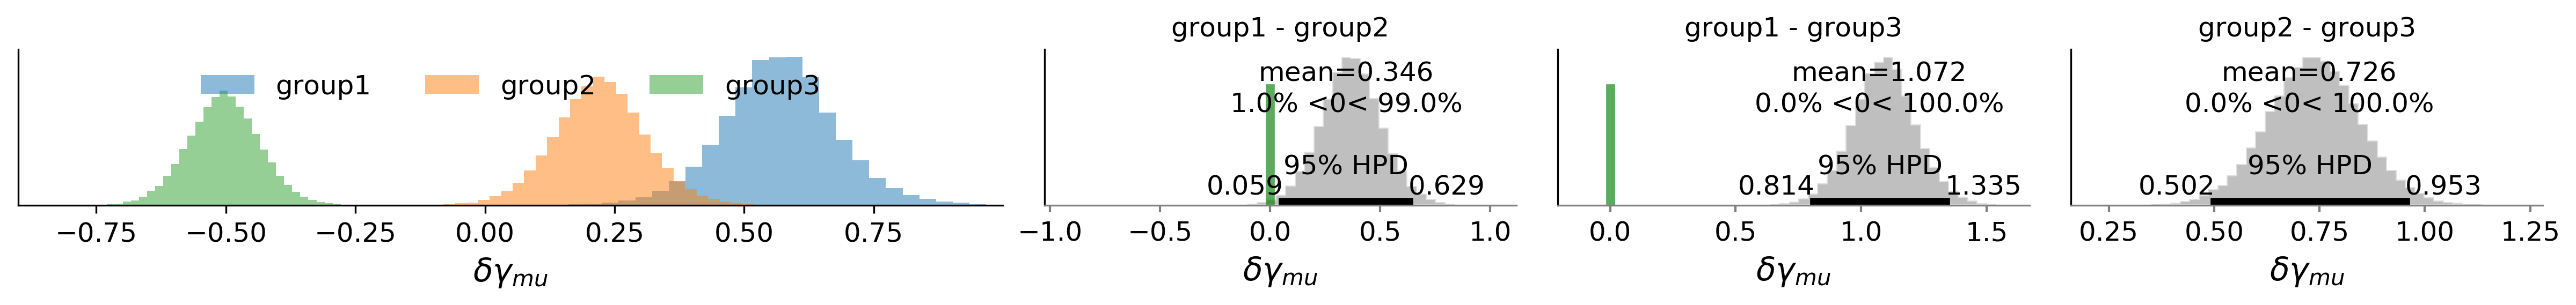

s


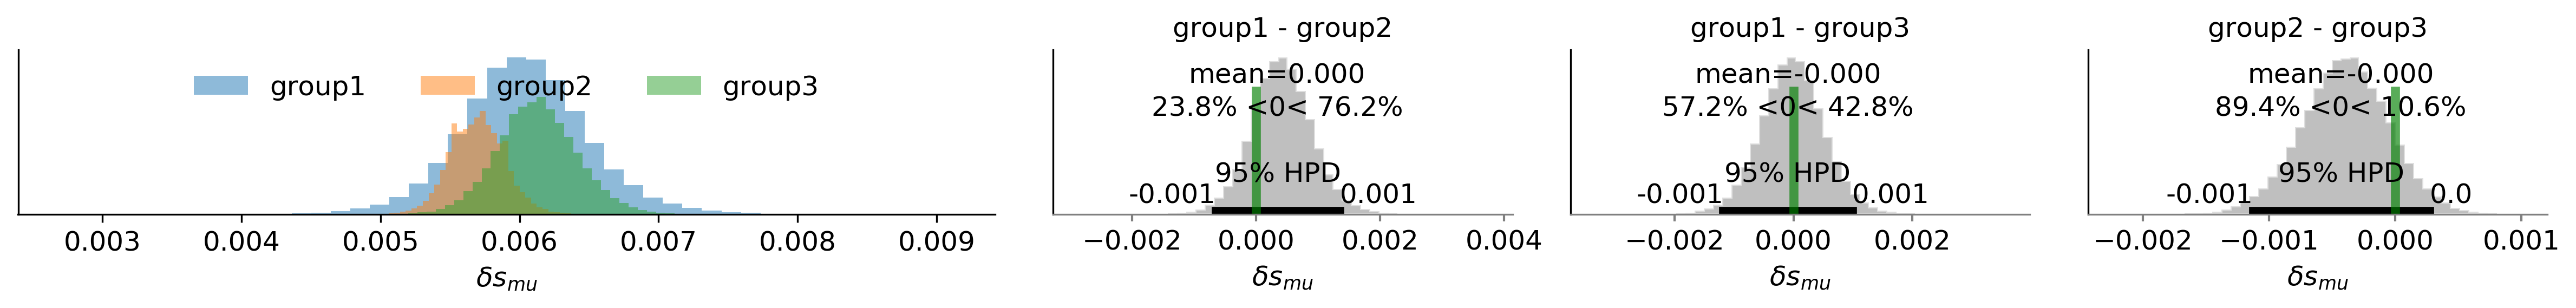

tau


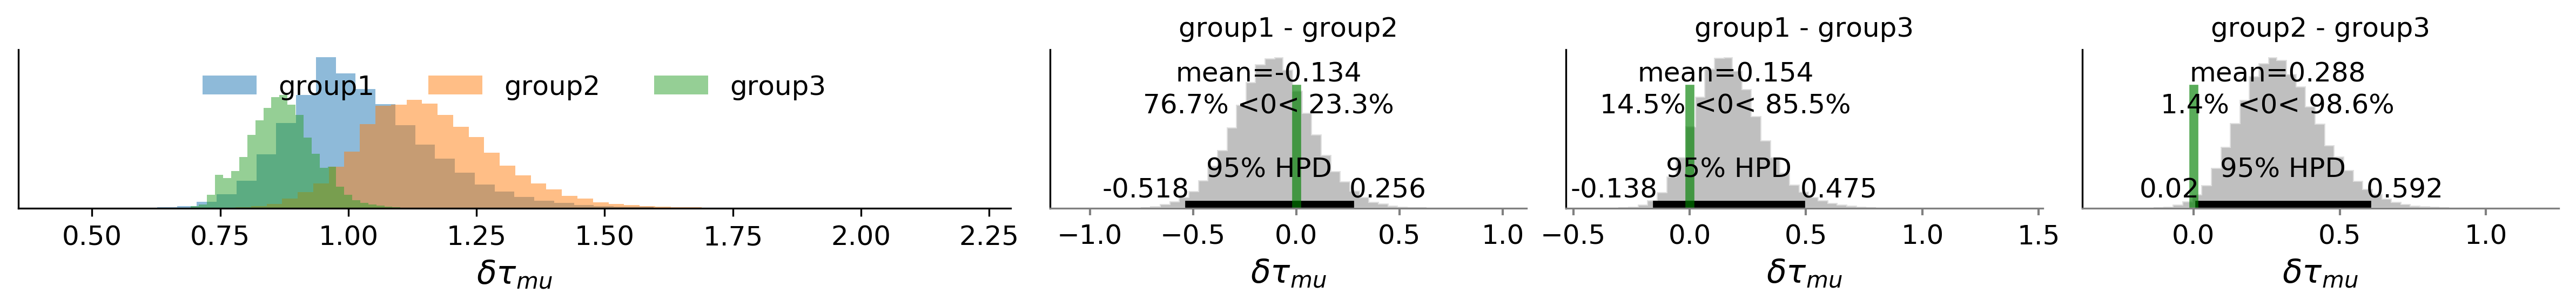

In [9]:
for parameter in ['v', 'gamma', 's', 'tau']:
    print(parameter)
    gb.plots.plot_node(hglam, parameter=parameter,
                       comparisons=[('group1', 'group2'), ('group1', 'group3'), ('group2', 'group3')]);
    plt.show()

In [32]:
from scipy.stats import ttest_ind
for p, parameter in zip(['v', 'gamma', 's', 'tau'],
                        [v, gamma, s, tau]):
    for a in ['group1', 'group2', 'group3']:
        for b in ['group1', 'group2', 'group3']:
            res = ttest_ind(parameter[a], parameter[b])
            print(p, a, 'vs', b)
            print('\tt = {:.2f}, p={:.2f}'.format(res.statistic, res.pvalue))

v group1 vs group1
	t = 0.00, p=1.00
v group1 vs group2
	t = -1.34, p=0.19
v group1 vs group3
	t = -0.09, p=0.93
v group2 vs group1
	t = 1.34, p=0.19
v group2 vs group2
	t = 0.00, p=1.00
v group2 vs group3
	t = 1.77, p=0.09
v group3 vs group1
	t = 0.09, p=0.93
v group3 vs group2
	t = -1.77, p=0.09
v group3 vs group3
	t = 0.00, p=1.00
gamma group1 vs group1
	t = 0.00, p=1.00
gamma group1 vs group2
	t = 2.58, p=0.02
gamma group1 vs group3
	t = 8.29, p=0.00
gamma group2 vs group1
	t = -2.58, p=0.02
gamma group2 vs group2
	t = 0.00, p=1.00
gamma group2 vs group3
	t = 6.75, p=0.00
gamma group3 vs group1
	t = -8.29, p=0.00
gamma group3 vs group2
	t = -6.75, p=0.00
gamma group3 vs group3
	t = 0.00, p=1.00
s group1 vs group1
	t = 0.00, p=1.00
s group1 vs group2
	t = 1.29, p=0.21
s group1 vs group3
	t = 0.56, p=0.58
s group2 vs group1
	t = -1.29, p=0.21
s group2 vs group2
	t = 0.00, p=1.00
s group2 vs group3
	t = -1.08, p=0.29
s group3 vs group1
	t = -0.56, p=0.58
s group3 vs group2
	t = 1.08, 

[[interpret results]]

With these plots, the researcher can easily infer that the groups did not differ with respect to their mean velocity parameters $v_{\mu}$ (top row, pairwise comparisons), mean accumulation noise $\sigma_{\mu}$ (third row), or scaling parameters $\tau_{\mu}$.

The groups differ, however, in the strength of their mean gaze bias $\gamma_{\mu}$ (second row): All differences between the groups were statistically meaningful (as inferred by the fact that the corresponding 95% HPD did not contain 0; second row, panels 2-4).

### Fidelity of parameter estimates (Recovery)

#### v

In [10]:
# Mean individual estimated parameters
hglam.estimates.groupby('group')['v'].mean()

group
group1    0.000099
group2    0.000111
group3    0.000106
Name: v, dtype: float64

In [11]:
# Group level estimates
hglam.estimates.groupby('group')['v_mu'].mean()

group
group1    0.000099
group2    0.000112
group3    0.000106
Name: v_mu, dtype: float64

In [12]:
# Mean individual generating parameters
{group: v[group].mean() for group in groups}

{'group1': 9.622294866138598e-05,
 'group2': 0.00011326744900569626,
 'group3': 9.717893152069714e-05}

$v$ estimates are pretty accurate. Groups 1 and 3 were overestimated slightly.

#### $\gamma$

In [13]:
# Mean individual estimated parameters
hglam.estimates.groupby('group')['gamma'].mean()

group
group1    0.563
group2    0.216
group3   -0.498
Name: gamma, dtype: float64

In [14]:
# Group level estimates
hglam.estimates.groupby('group')['gamma_mu'].mean()

group
group1    0.568157
group2    0.221764
group3   -0.504070
Name: gamma_mu, dtype: float64

In [15]:
# Mean individual generating parameters
{group: gamma[group].mean() for group in groups}

{'group1': 0.5460146742136827,
 'group2': 0.21943361156314992,
 'group3': -0.5354042984598719}

$\gamma$ estimates are very accurate.

#### $\sigma$

In [16]:
# Mean individual estimated parameters
hglam.estimates.groupby('group')['s'].mean()

group
group1    0.005928
group2    0.005534
group3    0.006014
Name: s, dtype: float64

In [17]:
# Group level estimates
hglam.estimates.groupby('group')['s_mu'].mean()

group
group1    0.006037
group2    0.005698
group3    0.006129
Name: s_mu, dtype: float64

In [18]:
# Mean individual generating parameters
{group: s[group].mean() for group in groups}

{'group1': 0.006059060921490469,
 'group2': 0.005754116834828575,
 'group3': 0.005937567897550887}

$\sigma$ was mostly recovered. Group 2 slightly over-, group 3 slightly underestimated.

#### $\tau$

In [19]:
# Mean individual estimated parameters
hglam.estimates.groupby('group')['tau'].mean()

group
group1    0.9540
group2    1.0960
group3    0.8605
Name: tau, dtype: float64

In [20]:
# Group level estimates
hglam.estimates.groupby('group')['tau_mu'].mean()

group
group1    1.023289
group2    1.156933
group3    0.869084
Name: tau_mu, dtype: float64

In [21]:
# Mean individual generating parameters
{group: tau[group].mean() for group in groups}

{'group1': 1.0997030526930103,
 'group2': 1.0309372211356156,
 'group3': 0.9867403500525868}

$\tau$ was mostly recovered. The order is mixed up, group 3 was underestimated, groups 1 and 2 underestimated.

# Conclusion

When faced with limited data from individuals, we can easily build and estimate hierarchical models, including conditional dependencies of certain model parameters. We recommend basic Metropolis sampling with a large number of tuning samples, and a large number of samples to retain. Chains should always be checked for convergence. The Bayesian inference that is used allows the researcher to answer relevant questions in a straightforward fashion. To this end, the toolbox provides basic functions for computation and visualization.